# ADCP Velocities

1. Visualizacion de las velocidades en coordenadas earth agregando la profundidad
2. Obtener running average
3. Rotar las coordenadas en direccion de la maxima varianza

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import matplotlib.dates as mdates
from matplotlib import ticker, cm
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
from sklearn.linear_model import LinearRegression

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Import velocity data in earth coordinates

__Sin filtrar__

In [3]:
e = np.load("data/east.npy")
n = np.load("data/north.npy")
v = np.load("data/vert.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'data/east.npy'

In [6]:
feb16 = xr.open_dataset("C:\\Users\\dhann\\Documents\\git\\dump\\adcp\\data\\adcp2012feb.nc")
# newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))

In [7]:
feb16

<xarray.Dataset>
Dimensions:       (beam: 4, bin: 25, time: 3127640)
Coordinates:
  * time          (time) datetime64[ns] 2012-02-16T14:45:00 ... 2012-03-14T18...
Dimensions without coordinates: beam, bin
Data variables: (12/30)
    east_vel      (time, bin) float64 ...
    north_vel     (time, bin) float64 ...
    vert_vel      (time, bin) float64 ...
    error_vel     (time, bin) float64 ...
    corr          (time, bin, beam) float64 ...
    status        (time, bin, beam) float64 ...
    ...            ...
    bt_corr       (time, beam) float64 ...
    bt_ampl       (time, beam) float64 ...
    bt_perc_good  (time, beam) float64 ...
    config        int32 ...
    name          object ...
    range         (bin) float64 ...
Attributes:
    src:      C://Users//vicho//Desktop//F16M5000.000

**Con datos filtrados**

In [5]:
earth = xr.open_dataset("data/earth_coord.nc")
earth.east

<xarray.DataArray 'east' (time: 2419200, bin: 25)>
[60480000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2012-02-17 ... 2012-03-08T23:54:59.500000
  * bin      (bin) float64 1.19 1.29 1.39 1.49 1.59 ... 3.19 3.29 3.39 3.49 3.59

### Import DC depth data

In [6]:
datos = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates//DC_ctds_fixed_gmt.mat")
dc1 = pd.DataFrame({'Datetime': pd.to_datetime(datos['tdate_dc1'], format='%d-%b-%Y %H:%M:%S'), 'Depth': datos['da_dc1'][:,0], 'Salinity': datos['s_dc1'][:,0], 'Temperature': datos['temp_dc1'][:,0]})
dc = dc1.set_index('Datetime')

### Import wind data

In [7]:
wind = sio.loadmat("data/met_20111027_20120510wdates.mat")
w = pd.DataFrame({'Location': np.full((len( wind['temp_C'][:,0])), 'Met Station'), 'Temperature': wind['temp_C'][:,0], 'Time GMT': wind['tz_met'][:,0], 'Datetime': pd.to_datetime(wind['DateString']), 'RH': wind['RH'][:,0], 'Direction': wind['wdir_deg'][:,0], 'Speed': wind['ws_mps'][:,0]})
w = w.set_index('Datetime')
w

,Location,Temperature,Time GMT,RH,Direction,Speed
Datetime,,,,,,
2011-10-27 22:42:00,Met Station,13.95036,734803.945833,91.987240,303.5512,1.266242
2011-10-27 22:48:00,Met Station,14.01408,734803.950000,90.972280,306.1161,2.487294
2011-10-27 22:54:00,Met Station,13.95633,734803.954167,91.727780,305.5775,2.683839
2011-10-27 23:00:00,Met Station,13.90469,734803.958333,92.541270,307.1723,2.955789
2011-10-27 23:06:00,Met Station,13.86476,734803.962500,91.611780,311.2245,2.432306
...,...,...,...,...,...,...
2012-05-10 18:54:00,Met Station,10.34039,734999.787500,3.862945,315.0378,3.336900
2012-05-10 19:00:00,Met Station,10.63775,734999.791667,3.992676,310.0413,3.963011
2012-05-10 19:06:00,Met Station,11.51026,734999.795833,3.879734,308.5242,4.403739


In [8]:
pd.DatetimeIndex(w.index).tz_localize('UTC').tz_convert('America/Los_Angeles')

DatetimeIndex(['2011-10-27 15:42:00-07:00', '2011-10-27 15:48:00-07:00',
               '2011-10-27 15:54:00-07:00', '2011-10-27 16:00:00-07:00',
               '2011-10-27 16:06:00-07:00', '2011-10-27 16:12:00-07:00',
               '2011-10-27 16:18:00-07:00', '2011-10-27 16:24:00-07:00',
               '2011-10-27 16:30:00-07:00', '2011-10-27 16:36:00-07:00',
               ...
               '2012-05-10 11:24:00-07:00', '2012-05-10 11:30:00-07:00',
               '2012-05-10 11:36:00-07:00', '2012-05-10 11:42:00-07:00',
               '2012-05-10 11:48:00-07:00', '2012-05-10 11:54:00-07:00',
               '2012-05-10 12:00:00-07:00', '2012-05-10 12:06:00-07:00',
               '2012-05-10 12:12:00-07:00', '2012-05-10 12:18:00-07:00'],
              dtype='datetime64[ns, America/Los_Angeles]', name='Datetime', length=47005, freq=None)

### Graficar earth coordinates

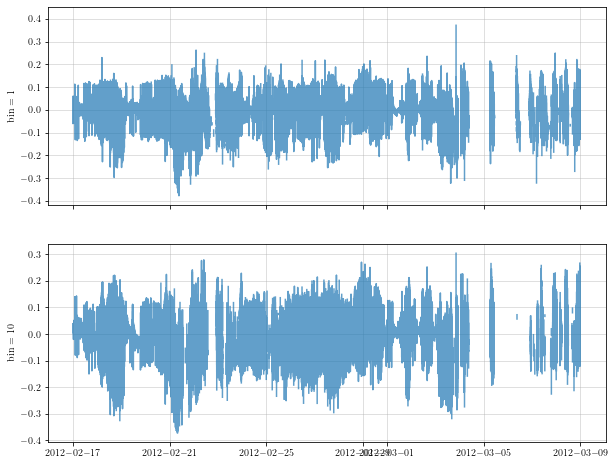

In [7]:
x = newfeb.time.values

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

ax1.plot(x,e[0,:], alpha=0.7);
# ax1.plot(x,n[0,:], alpha=0.7);
# ax1.plot(x,v[0,:], alpha=0.7);
# ax1.legend(["east", "north", "vertical"], loc='upper right');
ax1.set_ylabel('bin = 1')
ax1.grid(alpha=0.5)
# ax1.text(pd.to_datetime('2012-3-16'),2.95, '(A)')

ax2.plot(x,e[9,:], alpha=0.7);
# ax2.plot(x,n[9,:], alpha=0.7);
# ax2.plot(x,v[9,:], alpha=0.7);
# ax2.legend(["east", "north", "vertical"], loc='upper right');
ax2.set_ylabel('bin = 10')
ax2.grid(alpha=0.5)
# ax2.text(pd.to_datetime('2012-3-16'),18.5, '(B)')

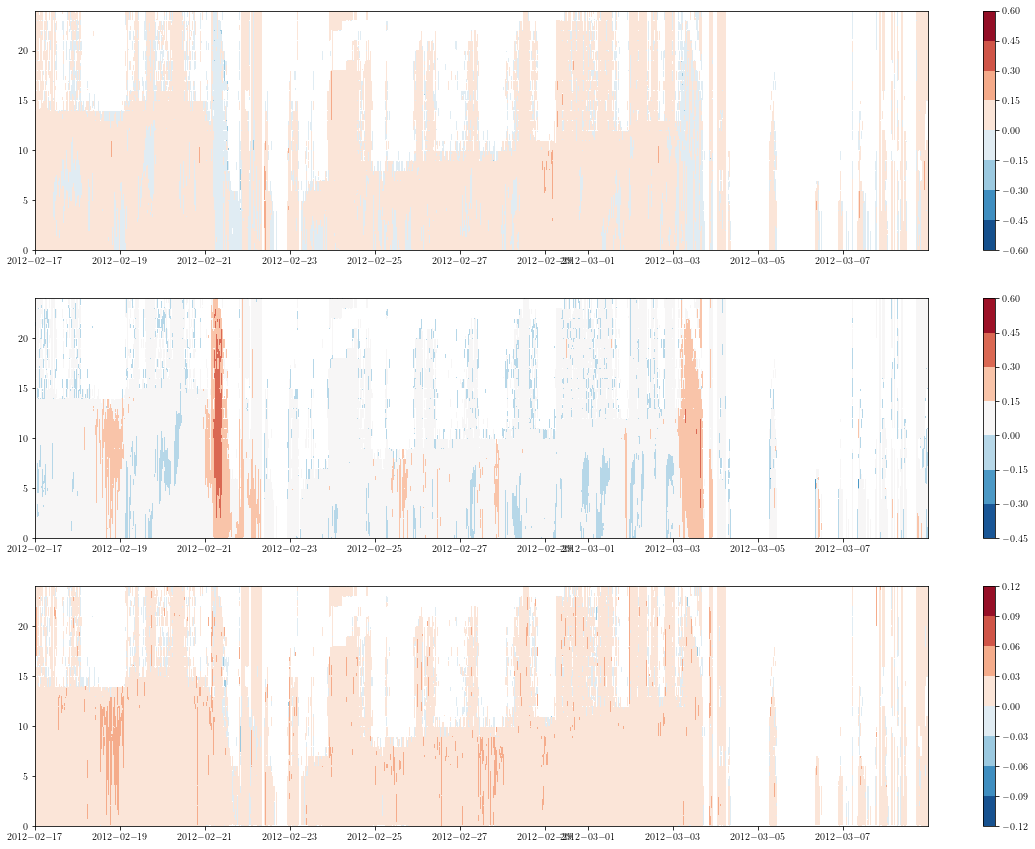

In [8]:
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, figsize=(20, 15))

contourf_ = ax1.contourf(newfeb.time.values,newfeb.bin.values, e, cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)

contourf_2 = ax2.contourf(newfeb.time.values,newfeb.bin.values, n, cmap=cm.RdBu_r)
cbar = plt.colorbar(contourf_2, ax=ax2)

contourf_3 = ax3.contourf(newfeb.time.values,newfeb.bin.values, v, cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_3, ax=ax3)

plt.show()

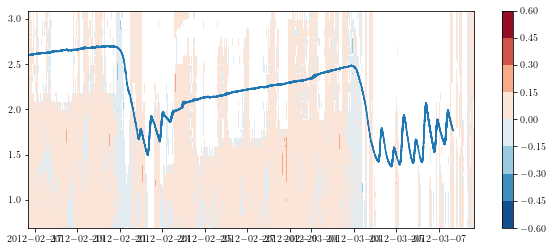

In [9]:
t = dc.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(0.69, 3.09, 25)

fig, (ax1) = plt.subplots(figsize=(10, 4), sharey=True)

ax1.plot(x, y_d)

contourf_ = ax1.contourf(newfeb.time.values,y_bin, e, cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)

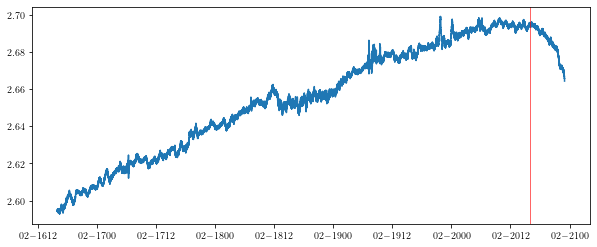

In [47]:
t = dc.loc[datetime.date(2012,2,17):datetime.datetime(2012,2,21,6,59,0)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.datetime(2012,2,21,6,59,0)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')

fig, (ax1) = plt.subplots(figsize=(10, 4))
ax1.plot(x, y_d)
ax1.axvline(x=datetime.datetime(2012,2,21,0,0,0), color='r', linewidth=0.6)

In [32]:

pd.DatetimeIndex(datetime.datetime(2012,3,3,8,0)).tz_localize('UTC').tz_convert('America/Los_Angeles')

TypeError: DatetimeIndex() must be called with a collection of some kind, datetime.datetime(2012, 3, 3, 8, 0) was passed

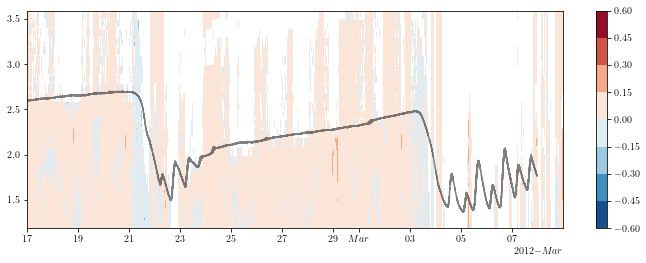

In [11]:
t = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.19, 3.59, 25)

fig, (ax1) = plt.subplots(figsize=(12, 4), sharey=True)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

ax1.plot(x, y_d,color='k',alpha=0.5)

contourf_ = ax1.contourf(newfeb.time.values,y_bin, e, cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)


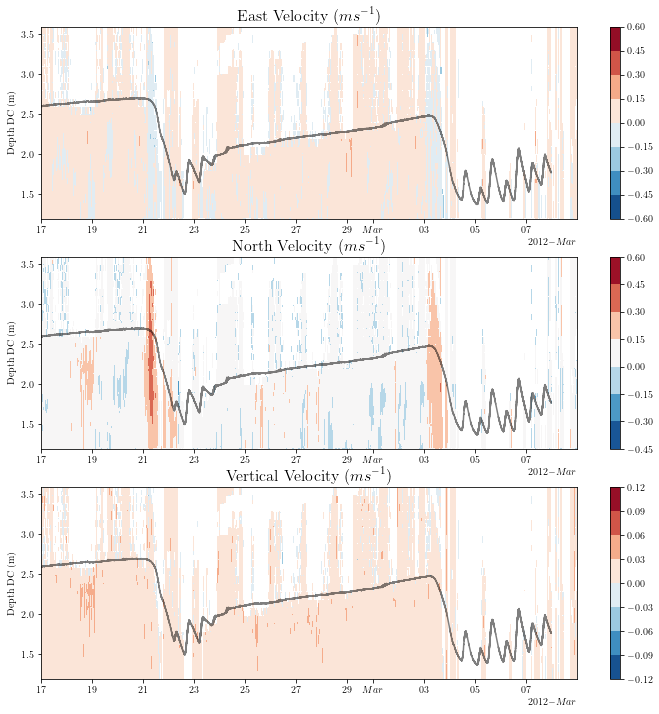

In [12]:
t = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.19, 3.59, 25)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, figsize=(12, 12))

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

ax1.set_title(r"East Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
ax1.plot(x, y_d,color='k',alpha=0.5)
contourf_ = ax1.contourf(newfeb.time.values,y_bin, e, cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)
ax1.set_ylabel(r"Depth DC (m)")

ax2.set_title(r"North Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax2.plot(x, y_d,color='k',alpha=0.5)
contourf_2 = ax2.contourf(newfeb.time.values,y_bin, n, cmap=cm.RdBu_r)
cbar = plt.colorbar(contourf_2, ax=ax2)
ax2.set_ylabel(r"Depth DC (m)")

ax3.set_title(r"Vertical Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax3.plot(x, y_d,color='k',alpha=0.5)
contourf_3 = ax3.contourf(newfeb.time.values,y_bin, v, cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_3, ax=ax3)
ax3.set_ylabel(r"Depth DC (m)")

plt.show()

**Con datos filtrados**

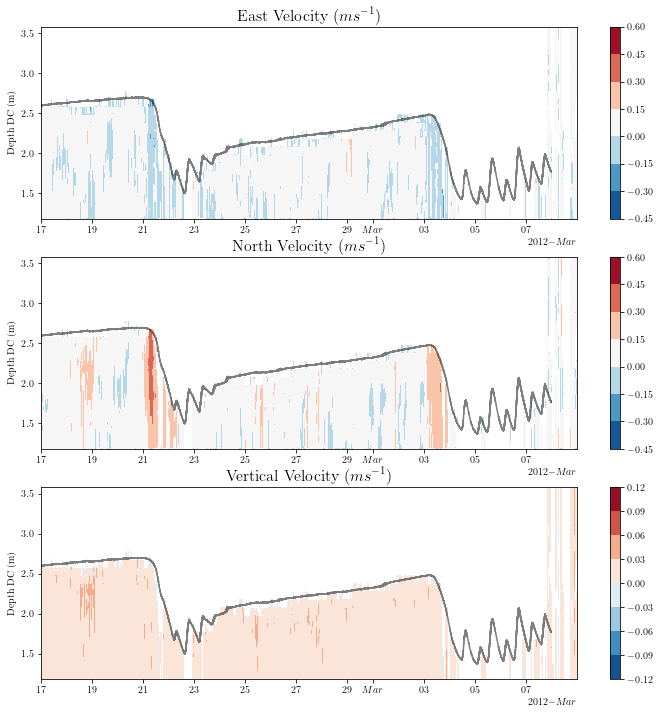

In [21]:
t = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.18, 3.58, 25)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, figsize=(12, 12))

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

ax1.set_title(r"East Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
ax1.plot(x, y_d,color='k',alpha=0.5)
contourf_ = ax1.contourf(earth.time.values,y_bin, np.transpose(earth.east.values), cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)
ax1.set_ylabel(r"Depth DC (m)")

ax2.set_title(r"North Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax2.plot(x, y_d,color='k',alpha=0.5)
contourf_2 = ax2.contourf(earth.time.values,y_bin, np.transpose(earth.north.values), cmap=cm.RdBu_r)
cbar = plt.colorbar(contourf_2, ax=ax2)
ax2.set_ylabel(r"Depth DC (m)")

ax3.set_title(r"Vertical Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax3.plot(x, y_d,color='k',alpha=0.5)
contourf_3 = ax3.contourf(earth.time.values,y_bin, np.transpose(earth.vertical.values), cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_3, ax=ax3)
ax3.set_ylabel(r"Depth DC (m)")

plt.show()

## Eliminar puntos de bin fuera del dominio

In [14]:
bin_ = np.linspace(1.19, 3.59, 25)
times = newfeb.time.values
da = xr.DataArray(np.transpose(e), coords=[times, bin_], dims=["time", "bin"])
dan = xr.DataArray(np.transpose(n), coords=[times, bin_], dims=["time", "bin"])
dav = xr.DataArray(np.transpose(v), coords=[times, bin_], dims=["time", "bin"])
j = 0
str_time = dc.loc[datetime.date(2012,2,17):datetime.datetime(2012,2,17,1,59,59)].index.strftime('%Y-%m-%d %H:%M:%S')
for i in str_time:
    if j != 0:
        b_ = dc.loc[i]['Depth']
        da = da.where(np.logical_not((da.time > pd.to_datetime(j)) & (da.time < pd.to_datetime(i)) & (da.bin > b_)))
    j = i
da

<xarray.DataArray (time: 2419200, bin: 25)>
array([[ 0.00151047, -0.00097713, -0.00184981, ...,         nan,
                nan,         nan],
       [-0.00355837,  0.00048475, -0.0013113 , ...,         nan,
                nan,         nan],
       [-0.00357915, -0.00101412, -0.00101412, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) datetime64[ns] 2012-02-17 ... 2012-03-08T23:54:59.500000
  * bin      (bin) float64 1.19 1.29 1.39 1.49 1.59 ... 3.19 3.29 3.39 3.49 3.59

In [9]:
eastt = earth.sel(time=slice('2012-02-17','2012-03-06')).east.values
northtt = earth.sel(time=slice('2012-02-17','2012-03-06')).north.values
timett = earth.sel(time=slice('2012-02-17','2012-03-06')).time.values

In [10]:
X = eastt[~np.isnan(eastt)].reshape(-1, 1)
y = northtt[~np.isnan(northtt)].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
print(reg.intercept_)
print(reg.coef_)

[0.00727884]
[[-0.84313474]]


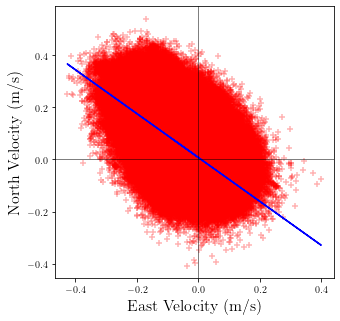

In [11]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X, y, c='r', marker='+', alpha=0.3)
ax1.plot(X,y_pred, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

In [31]:
X = e[~np.isnan(e)].reshape(-1, 1)
y = n[~np.isnan(n)].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
print(reg.intercept_)
print(reg.coef_)

[0.0083462]
[[-0.69854995]]


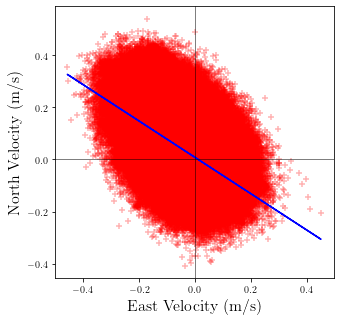

In [32]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X, y, c='r', marker='+', alpha=0.3)
ax1.plot(X,y_pred, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

In [16]:
d2 = xr.DataArray(np.transpose(e), coords=[times, bin_], dims=["time", "bin"])

In [17]:
times = newfeb.time.values
dae = xr.DataArray(np.transpose(e), coords=[times, bin_], dims=["time", "bin"])
dan = xr.DataArray(np.transpose(n), coords=[times, bin_], dims=["time", "bin"])
dav = xr.DataArray(np.transpose(v), coords=[times, bin_], dims=["time", "bin"])
ds = dae.rename("east").to_dataset()
ds["north"] = dan
ds["vertical"] = dav
ds

<xarray.Dataset>
Dimensions:   (bin: 25, time: 2419200)
Coordinates:
  * time      (time) datetime64[ns] 2012-02-17 ... 2012-03-08T23:54:59.500000
  * bin       (bin) float64 1.19 1.29 1.39 1.49 1.59 ... 3.29 3.39 3.49 3.59
Data variables:
    east      (time, bin) float64 0.00151 -0.0009771 -0.00185 ... nan nan nan
    north     (time, bin) float64 0.004091 -0.002785 -0.0009201 ... nan nan nan
    vertical  (time, bin) float64 0.0005364 0.0003487 0.0005375 ... nan nan nan

In [18]:
def del_bin(ds_vel, dc_depht):
    j = 0
    t = dc_depht.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)].index
    str_time = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles').strftime('%Y-%m-%d %H:%M:%S')
    for i in str_time:
        if j != 0:
            b_ = dc.loc[i]['Depth']
            ds_vel = ds_vel.where(np.logical_not((ds_vel.time > pd.to_datetime(j)) & (ds_vel.time < pd.to_datetime(i)) & (ds_vel.bin > b_)))
        j = i
    return ds_vel

### Moving Average

In [19]:
e_df = pd.DataFrame(np.transpose(e), columns = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25'])
e_df.index = newfeb.time.values
e_df = e_df.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

rolling = e_df['bin_1'].rolling(window=10)
rolling_mean = rolling.mean()
period = len(e_df.index)//10
w = []
for i in range(len(e_df.index)):
    if i%10 == 0:
        w.append(True)
#         w = np.append(w, [True], 0)
    else:
#         w = np.append(w, [False], 0)
        w.append(False)
# rolling_mean[w]
# peso = pd.date_range(start=newfeb.time.values[0], end=newfeb.time.values[-1], periods=None, freq='5S')
# rolling_mean.loc[peso]
e_df['blank'] = np.zeros(len(e_df))
newe = e_df['blank'][w].to_frame()
newe['prueba'] = rolling_mean[w]

NameError: name 'df_east' is not defined

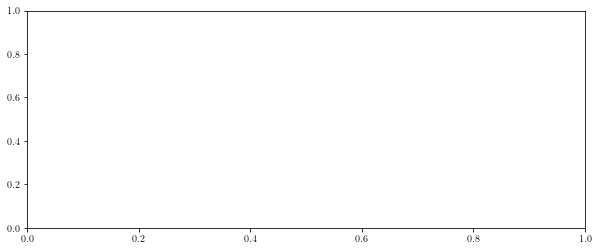

In [20]:
# fig, (ax1) = plt.subplots(figsize=(10, 4))
# # ax1.plot(e_df.index, e_df['bin_1'].values)
# ax1.plot(df_east.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]['bin_10'].index, df_east.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]['bin_10'].values)
# ax1.plot(rolling_mean[w].index, rolling_mean[w].values)

# # ax1.legend(["normal", "rolling"], loc='upper right')

__Funcion__

In [14]:
# def mov_avg(array, time_values, nsmooth):
#     df = pd.DataFrame(np.transpose(array), columns = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25'])
#     df.index = time_values
#     mask = []
#     for i in range(len(time_values)):
#         if i%nsmooth == 0:
#             mask.append(True)
#         else:
#             mask.append(False)
#     df['blank'] = np.zeros(len(df))
#     new_df = df['blank'][mask].to_frame()
#     for i in df.columns:
#         rolling = df[i].rolling(window=nsmooth)
#         rolling_mean = rolling.mean()
#         masked_rolling_mean = rolling_mean[mask]
#         new_df[i] = masked_rolling_mean
#     new_df.drop('blank', inplace=True, axis=1)
#     return new_df

def mov_avg(array, time_values, nsmooth):
    df = pd.DataFrame(np.transpose(array), columns = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25'])
    df.index = time_values
    mask = []
    for i in range(len(time_values)):
        if i%nsmooth == 0:
            mask.append(True)
        else:
            mask.append(False)
    df['blank'] = np.zeros(len(df))
    new_df = df['blank'][mask].to_frame()
    for i in df.columns:
        rolling = df[i].rolling(window=nsmooth, min_periods=1)
        rolling_mean = rolling.mean()
        masked_rolling_mean = rolling_mean[mask]
        new_df[i] = masked_rolling_mean
    new_df.drop('blank', inplace=True, axis=1)
    return new_df

__CADA 5 SEGUNDOS__

In [15]:
df_east = mov_avg(np.transpose(earth.east.values), earth.time.values, nsmooth=10)
df_north = mov_avg(np.transpose(earth.north.values), earth.time.values, nsmooth=10)
df_vert = mov_avg(np.transpose(earth.vertical.values), earth.time.values, nsmooth=10)

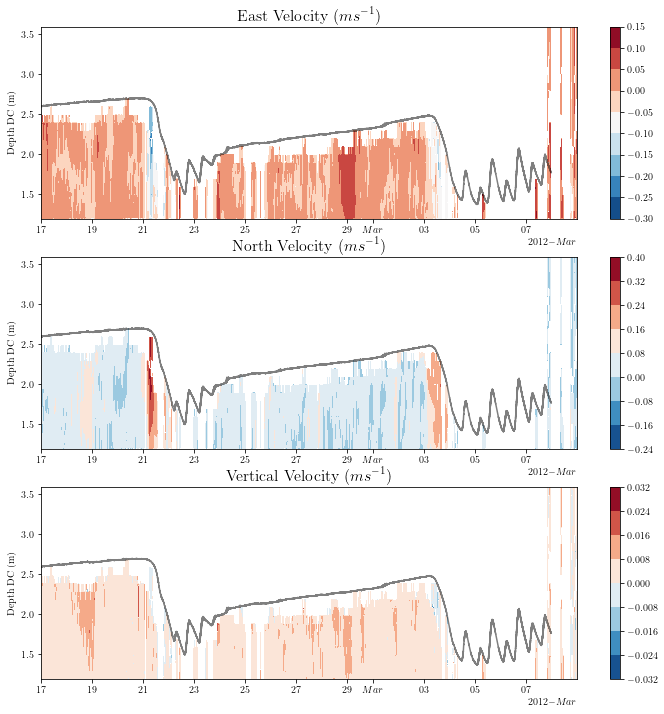

In [29]:
t = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.19, 3.59, 25)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, figsize=(12, 12))

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

ax1.set_title(r"East Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
ax1.plot(x, y_d,color='k',alpha=0.5)
contourf_ = ax1.contourf(df_east.index,y_bin, np.transpose(df_east.values), cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)
ax1.set_ylabel(r"Depth DC (m)")

ax2.set_title(r"North Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax2.plot(x, y_d,color='k',alpha=0.5)
contourf_2 = ax2.contourf(df_north.index,y_bin, np.transpose(df_north.values), cmap=cm.RdBu_r)
cbar = plt.colorbar(contourf_2, ax=ax2)
ax2.set_ylabel(r"Depth DC (m)")

ax3.set_title(r"Vertical Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax3.plot(x, y_d,color='k',alpha=0.5)
contourf_3 = ax3.contourf(df_vert.index ,y_bin, np.transpose(df_vert.values), cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_3, ax=ax3)
ax3.set_ylabel(r"Depth DC (m)")

plt.show()

__CADA 10 SEGUNDOS__

In [18]:
df_east10 = mov_avg(np.transpose(earth.east.values), earth.time.values, nsmooth=20)
df_north10 = mov_avg(np.transpose(earth.north.values), earth.time.values, nsmooth=20)
df_vert10 = mov_avg(np.transpose(earth.vertical.values), earth.time.values, nsmooth=20)

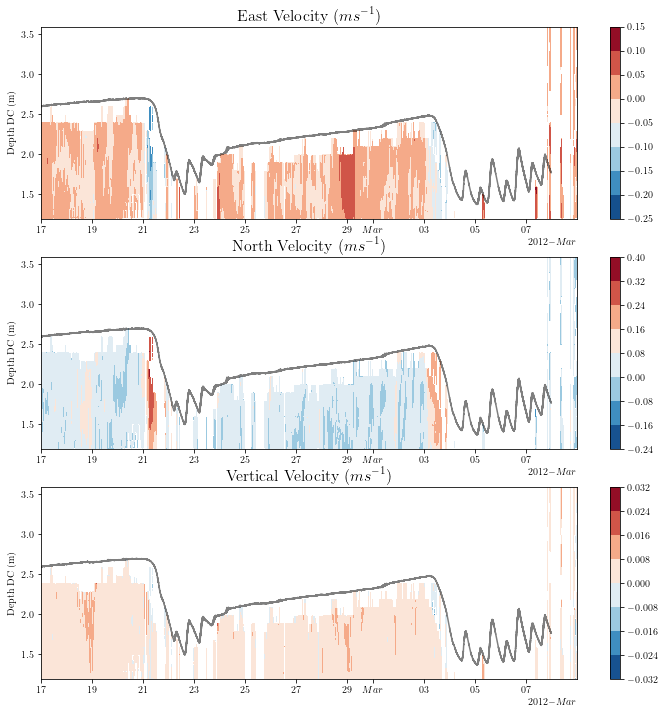

In [93]:
t = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)].index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]['Depth']
x = pd.DatetimeIndex(t).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.19, 3.59, 25)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, figsize=(12, 12))

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

ax1.set_title(r"East Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
ax1.plot(x, y_d,color='k',alpha=0.5)
contourf_ = ax1.contourf(df_east10.index,y_bin, np.transpose(df_east10.values), cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_, ax=ax1)
ax1.set_ylabel(r"Depth DC (m)")

ax2.set_title(r"North Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax2.plot(x, y_d,color='k',alpha=0.5)
contourf_2 = ax2.contourf(df_north10.index,y_bin, np.transpose(df_north10.values), cmap=cm.RdBu_r)
cbar = plt.colorbar(contourf_2, ax=ax2)
ax2.set_ylabel(r"Depth DC (m)")

ax3.set_title(r"Vertical Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax3.plot(x, y_d,color='k',alpha=0.5)
contourf_3 = ax3.contourf(df_vert10.index ,y_bin, np.transpose(df_vert10.values), cmap=cm.RdBu_r)
cbar = fig.colorbar(contourf_3, ax=ax3)
ax3.set_ylabel(r"Depth DC (m)")

plt.show()

In [12]:
X10 = df_east10.values[~np.isnan(df_east10.values)].reshape(-1, 1)
y10 = df_north10.values[~np.isnan(df_north10.values)].reshape(-1, 1)

reg1 = LinearRegression().fit(X10, y10)
y_pred1 = reg1.predict(X10)
print(reg1.intercept_)
print(reg1.coef_)

[0.00181878]
[[-1.05612772]]


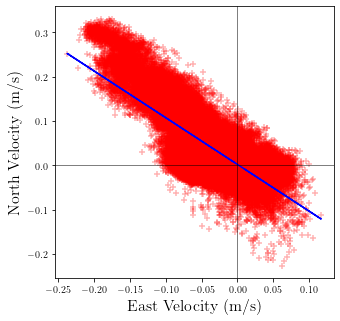

In [13]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10, y10, c='r', marker='+', alpha=0.3)
ax1.plot(X10,y_pred1, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

### Rotation in direction of maximum variance

Se realiza por los tramos 17 al 22 de febrero y 25 a 4 de marzo

__17 al 22 en todos los bin__

CADA 10 SEGUNDOS (rolling mean)

In [14]:
df_east10_1 = df_east10.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
df_north10_1 = df_north10.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

X10_1 = df_east10_1.values[~np.isnan(df_east10_1.values)].reshape(-1, 1)
y10_1 = df_north10_1.values[~np.isnan(df_north10_1.values)].reshape(-1, 1)

In [15]:
reg1 = LinearRegression().fit(X10_1, y10_1)
y_pred1 = reg1.predict(X10_1)
print(reg1.intercept_)
print(reg1.coef_)

[0.00212366]
[[-1.08359937]]


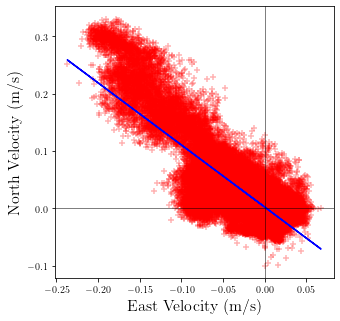

In [16]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10_1, y10_1, c='r', marker='+', alpha=0.3)
ax1.plot(X10_1,y_pred1, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

CADA 5 SEGUNDOS (rolling mean)

In [98]:
df_east5_1 = df_east.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
df_north5_1 = df_north.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

X5_1 = df_east5_1.values[~np.isnan(df_east5_1.values)].reshape(-1, 1)
y5_1 = df_north5_1.values[~np.isnan(df_north5_1.values)].reshape(-1, 1)

In [99]:
reg2 = LinearRegression().fit(X5_1, y5_1)
y_pred2 = reg2.predict(X5_1)
print(reg2.intercept_)
print(reg2.coef_)

[0.00241242]
[[-1.10769103]]


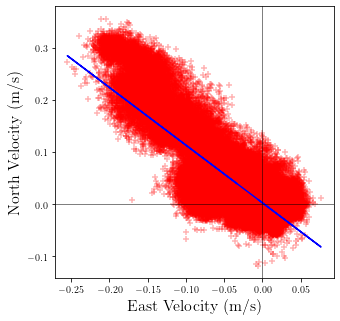

In [100]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X5_1, y5_1, c='r', marker='+', alpha=0.3)
ax1.plot(X5_1,y_pred2, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

SIN ROLLING MEAN

In [101]:
X1_1 = e[:,:691200][~np.isnan(e[:,:691200])].reshape(-1, 1)
y1_1 = n[:,:691200][~np.isnan(n[:,:691200])].reshape(-1, 1)

In [102]:
reg3 = LinearRegression().fit(X1_1, y1_1)
y_pred3 = reg3.predict(X1_1)
print(reg3.intercept_)
print(reg3.coef_)

[0.01031381]
[[-0.83168827]]


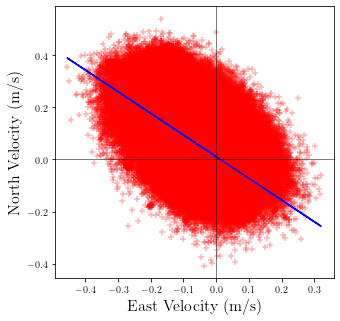

In [103]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X1_1, y1_1, c='r', marker='+', alpha=0.3)
ax1.plot(X1_1,y_pred3, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

__17 al 22 en bin 1__

CADA 10 SEGUNDOS (rolling mean)

In [104]:
df_east10_1 = df_east10.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
df_north10_1 = df_north10.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

X10_1 = df_east10_1['bin_1'].values[~np.isnan(df_east10_1['bin_1'].values)].reshape(-1, 1)
y10_1 = df_north10_1['bin_1'].values[~np.isnan(df_north10_1['bin_1'].values)].reshape(-1, 1)

In [105]:
reg4 = LinearRegression().fit(X10_1, y10_1)
y_pred4 = reg4.predict(X10_1)
print(reg4.intercept_)
print(reg4.coef_)

[-0.00261838]
[[-0.83393409]]


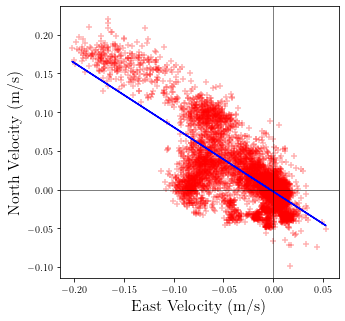

In [106]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10_1, y10_1, c='r', marker='+', alpha=0.3)
ax1.plot(X10_1,y_pred4, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

CADA 5 SEGUNDOS (rolling mean)

In [107]:
df_east5_1 = df_east.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
df_north5_1 = df_north.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

X5_1 = df_east5_1['bin_1'].values[~np.isnan(df_east5_1['bin_1'].values)].reshape(-1, 1)
y5_1 = df_north5_1['bin_1'].values[~np.isnan(df_north5_1['bin_1'].values)].reshape(-1, 1)

In [108]:
reg5 = LinearRegression().fit(X5_1, y5_1)
y_pred5 = reg5.predict(X5_1)
print(reg5.intercept_)
print(reg5.coef_)

[-0.00192812]
[[-0.86071214]]


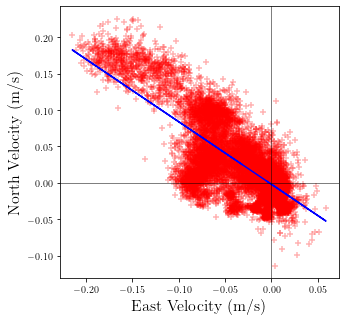

In [109]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X5_1, y5_1, c='r', marker='+', alpha=0.3)
ax1.plot(X5_1,y_pred5, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

SIN ROLLING MEAN

In [110]:
X1_1 = e[0,:691200][~np.isnan(e[0,:691200])].reshape(-1, 1)
y1_1 = n[0,:691200][~np.isnan(n[0,:691200])].reshape(-1, 1)

In [111]:
reg6 = LinearRegression().fit(X1_1, y1_1)
y_pred6 = reg6.predict(X1_1)
print(reg6.intercept_)
print(reg6.coef_)

[0.00298944]
[[-0.79977095]]


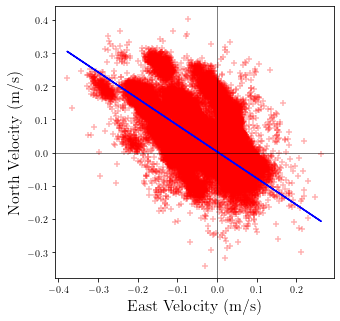

In [112]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X1_1, y1_1, c='r', marker='+', alpha=0.3)
ax1.plot(X1_1,y_pred6, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

__17 al 22 en bin 10__

CADA 10 SEGUNDOS (rolling mean)

In [113]:
df_east10_1 = df_east10.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
df_north10_1 = df_north10.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

X10_1 = df_east10_1['bin_10'].values[~np.isnan(df_east10_1['bin_10'].values)].reshape(-1, 1)
y10_1 = df_north10_1['bin_10'].values[~np.isnan(df_north10_1['bin_10'].values)].reshape(-1, 1)

In [114]:
reg7 = LinearRegression().fit(X10_1, y10_1)
y_pred7 = reg7.predict(X10_1)
print(reg7.intercept_)
print(reg7.coef_)

[0.00378497]
[[-1.010099]]


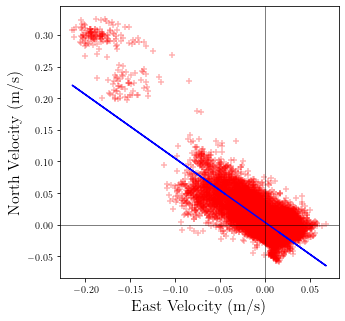

In [115]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10_1, y10_1, c='r', marker='+', alpha=0.3)
ax1.plot(X10_1,y_pred7, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

CADA 5 SEGUNDOS (rolling mean)

In [16]:
df_east5_1 = df_east.loc[datetime.date(2012,2,20):datetime.date(2012,2,22)]
df_north5_1 = df_north.loc[datetime.date(2012,2,20):datetime.date(2012,2,22)]

X5_1 = df_east5_1['bin_10'].values[~np.isnan(df_east5_1['bin_10'].values)].reshape(-1, 1)
y5_1 = df_north5_1['bin_10'].values[~np.isnan(df_north5_1['bin_10'].values)].reshape(-1, 1)

In [17]:
reg8 = LinearRegression().fit(X5_1, y5_1)
y_pred8 = reg8.predict(X5_1)
print(reg8.intercept_)
print(reg8.coef_)

[0.00761517]
[[-1.31606417]]


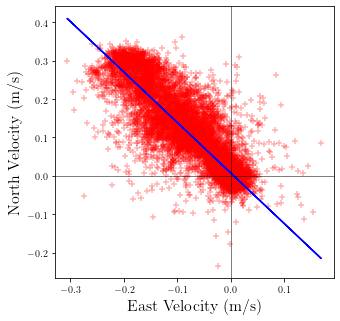

In [18]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X5_1, y5_1, c='r', marker='+', alpha=0.3)
ax1.plot(X5_1,y_pred8, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

In [27]:
def earth_to_uv(dfe, dfn, a):
    alpha = np.arctan(a)
    t, b = dfe.shape
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]])
    columns = dfe.columns
    u = np.zeros((0,t))
    v = np.zeros((0,t))
    for i in columns:
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]])
        ui, vi = np.tensordot(M, bin_, 1)
        u = np.concatenate((u, ui), axis=0)
        v = np.concatenate((v, vi), axis=0)
    return u, v

In [26]:
t, b = df_east5_1.shape
M = np.array([[-np.cos(1.5), np.sin(1.5)],
              [np.sin(1.5), np.cos(1.5)]])
np.cos(30)

0.15425144988758405

In [28]:
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

u1, v1 = earth_to_uv(df_east5_1, df_north5_1, 1.53013513)
dfu1 = pd.DataFrame(np.transpose(u1), columns=columnas)
dfu1.index = df_east5_1.index
dfv1 = pd.DataFrame(np.transpose(v1), columns=columnas)
dfv1.index = df_east5_1.index


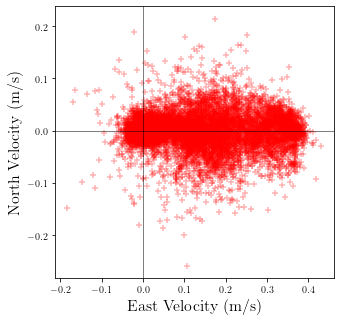

In [29]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(dfu1['bin_10'], dfv1['bin_10'], c='r', marker='+', alpha=0.3)
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

SIN ROLLING MEAN

In [119]:
X1_1 = e[9,:691200][~np.isnan(e[9,:691200])].reshape(-1, 1)
y1_1 = n[9,:691200][~np.isnan(n[9,:691200])].reshape(-1, 1)

In [120]:
reg9 = LinearRegression().fit(X1_1, y1_1)
y_pred9 = reg9.predict(X1_1)
print(reg9.intercept_)
print(reg9.coef_)

[0.00789446]
[[-0.97984454]]


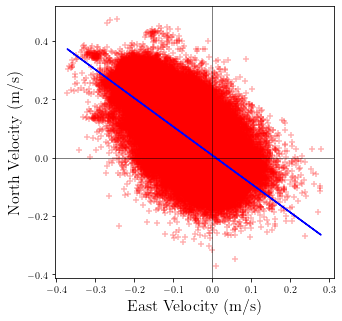

In [121]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X1_1, y1_1, c='r', marker='+', alpha=0.3)
ax1.plot(X1_1,y_pred9, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

__25 al 4 en todos los bin__

CADA 10 SEGUNDOS (rolling mean)

In [122]:
df_east10_2 = df_east10.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
df_north10_2 = df_north10.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

X10_2 = df_east10_2.values[~np.isnan(df_east10_2.values)].reshape(-1, 1)
y10_2 = df_north10_2.values[~np.isnan(df_north10_2.values)].reshape(-1, 1)

In [123]:
reg10 = LinearRegression().fit(X10_2, y10_2)
y_pred10 = reg10.predict(X10_2)
print(reg10.intercept_)
print(reg10.coef_)

[0.00203681]
[[-1.03903352]]


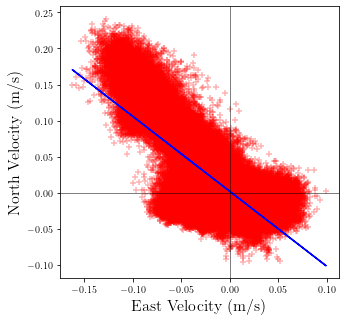

In [124]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10_2, y10_2, c='r', marker='+', alpha=0.3)
ax1.plot(X10_2,y_pred10, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

CADA 5 SEGUNDOS (rolling mean)

In [125]:
df_east5_2 = df_east.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
df_north5_2 = df_north.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

X5_2 = df_east5_2.values[~np.isnan(df_east5_2.values)].reshape(-1, 1)
y5_2 = df_north5_2.values[~np.isnan(df_north5_2.values)].reshape(-1, 1)

In [126]:
reg12 = LinearRegression().fit(X5_2, y5_2)
y_pred12 = reg12.predict(X5_2)
print(reg12.intercept_)
print(reg12.coef_)

[0.00247838]
[[-1.03577885]]


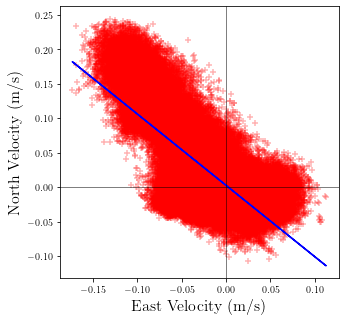

In [127]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X5_2, y5_2, c='r', marker='+', alpha=0.3)
ax1.plot(X5_2,y_pred12, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

SIN ROLLING MEAN

In [128]:
X1_2 = e[:,1036800:1958400][~np.isnan(e[:,1036800:1958400])].reshape(-1, 1)
y1_2 = n[:,1036800:1958400][~np.isnan(n[:,1036800:1958400])].reshape(-1, 1)

In [129]:
reg13 = LinearRegression().fit(X1_2, y1_2)
y_pred13 = reg13.predict(X1_2)
print(reg13.intercept_)
print(reg13.coef_)

[0.00836455]
[[-0.64975434]]


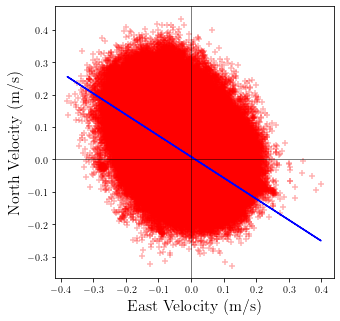

In [130]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X1_2, y1_2, c='r', marker='+', alpha=0.3)
ax1.plot(X1_2,y_pred13, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

__25 al 04 en bin 1__

CADA 10 SEGUNDOS (rolling mean)

In [131]:
df_east10_2 = df_east10.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
df_north10_2 = df_north10.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

X10_2 = df_east10_2['bin_1'].values[~np.isnan(df_east10_2['bin_1'].values)].reshape(-1, 1)
y10_2 = df_north10_2['bin_1'].values[~np.isnan(df_north10_2['bin_1'].values)].reshape(-1, 1)

In [132]:
reg14 = LinearRegression().fit(X10_2, y10_2)
y_pred14 = reg14.predict(X10_2)
print(reg14.intercept_)
print(reg14.coef_)

[-0.00190618]
[[-1.05592665]]


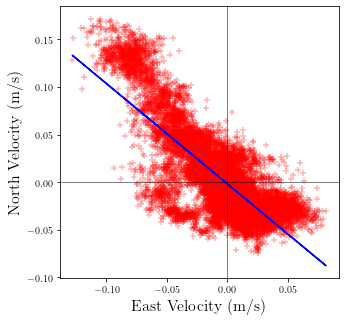

In [133]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10_2, y10_2, c='r', marker='+', alpha=0.3)
ax1.plot(X10_2,y_pred14, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

CADA 5 SEGUNDOS (rolling mean)

In [134]:
df_east5_2 = df_east.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
df_north5_2 = df_north.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

X5_2 = df_east5_2['bin_1'].values[~np.isnan(df_east5_2['bin_1'].values)].reshape(-1, 1)
y5_2 = df_north5_2['bin_1'].values[~np.isnan(df_north5_2['bin_1'].values)].reshape(-1, 1)

In [135]:
reg15 = LinearRegression().fit(X5_2, y5_2)
y_pred15 = reg15.predict(X5_2)
print(reg15.intercept_)
print(reg15.coef_)

[-0.00163734]
[[-1.05674632]]


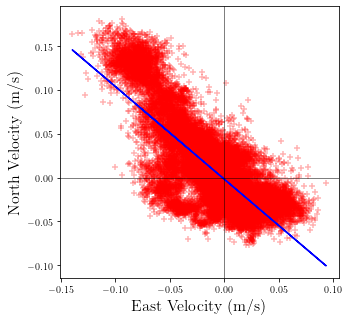

In [136]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X5_2, y5_2, c='r', marker='+', alpha=0.3)
ax1.plot(X5_2,y_pred15, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

SIN ROLLING MEAN

In [137]:
X1_2 = e[0,1036800:1958400][~np.isnan(e[0,1036800:1958400])].reshape(-1, 1)
y1_2 = n[0,1036800:1958400][~np.isnan(n[0,1036800:1958400])].reshape(-1, 1)

In [138]:
reg16 = LinearRegression().fit(X1_2, y1_2)
y_pred16 = reg16.predict(X1_2)
print(reg16.intercept_)
print(reg16.coef_)

[0.00126804]
[[-0.92227812]]


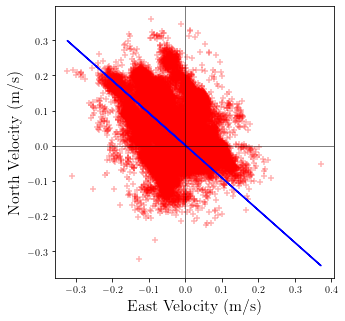

In [139]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X1_2, y1_2, c='r', marker='+', alpha=0.3)
ax1.plot(X1_2,y_pred16, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

__25 al 04 en bin 10__

CADA 10 SEGUNDOS (rolling mean)

In [140]:
df_east10_2 = df_east10.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
df_north10_2 = df_north10.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

X10_2 = df_east10_2['bin_10'].values[~np.isnan(df_east10_2['bin_10'].values)].reshape(-1, 1)
y10_2 = df_north10_2['bin_10'].values[~np.isnan(df_north10_2['bin_10'].values)].reshape(-1, 1)

In [141]:
reg17 = LinearRegression().fit(X10_2, y10_2)
y_pred17 = reg17.predict(X10_2)
print(reg17.intercept_)
print(reg17.coef_)

[0.01326807]
[[-1.4044867]]


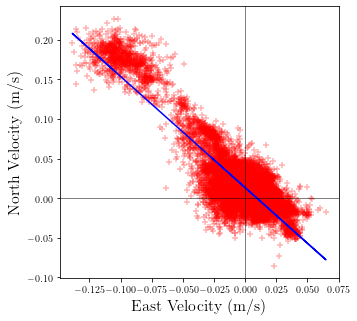

In [142]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X10_2, y10_2, c='r', marker='+', alpha=0.3)
ax1.plot(X10_2,y_pred17, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

CADA 5 SEGUNDOS (rolling mean)

In [143]:
df_east5_2 = df_east.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
df_north5_2 = df_north.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

X5_2 = df_east5_2['bin_10'].values[~np.isnan(df_east5_2['bin_10'].values)].reshape(-1, 1)
y5_2 = df_north5_2['bin_10'].values[~np.isnan(df_north5_2['bin_10'].values)].reshape(-1, 1)

In [144]:
reg18 = LinearRegression().fit(X5_2, y5_2)
y_pred18 = reg18.predict(X5_2)
print(reg18.intercept_)
print(reg18.coef_)

[0.01337949]
[[-1.37075691]]


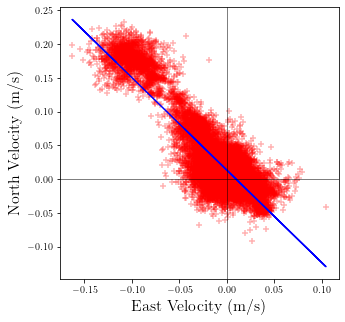

In [145]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X5_2, y5_2, c='r', marker='+', alpha=0.3)
ax1.plot(X5_2,y_pred18, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

SIN ROLLING MEAN

In [146]:
X1_2 = e[9,1036800:1958400][~np.isnan(e[9,1036800:1958400])].reshape(-1, 1)
y1_2 = n[9,1036800:1958400][~np.isnan(n[9,1036800:1958400])].reshape(-1, 1)

In [147]:
reg19 = LinearRegression().fit(X1_2, y1_2)
y_pred19 = reg19.predict(X1_2)
print(reg19.intercept_)
print(reg19.coef_)

[0.01677151]
[[-0.68944043]]


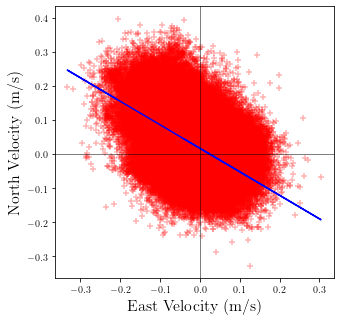

In [148]:
fig, (ax1) = plt.subplots(figsize=(5, 5))

ax1.scatter(X1_2, y1_2, c='r', marker='+', alpha=0.3)
ax1.plot(X1_2,y_pred19, c='b')
ax1.set_xlabel(r"East Velocity (m/s)",fontsize=16)
ax1.set_ylabel(r"North Velocity (m/s)",fontsize=16)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)

## Transformacion de coordenadas a u-v

__Del 17 al 22__

In [22]:
dfe = df_east.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
dfn = df_north.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

In [23]:
def earth_to_uv(dfe, dfn, alpha):
    t, b = dfe.shape
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]])
    columns = dfe.columns
    u = np.zeros((0,t))
    v = np.zeros((0,t))
    for i in columns:
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]])
        ui, vi = np.tensordot(M, bin_, 1)
        u = np.concatenate((u, ui), axis=0)
        v = np.concatenate((v, vi), axis=0)
    return u, v

In [24]:
u, v = earth_to_uv(dfe, dfn, 1.10769103)

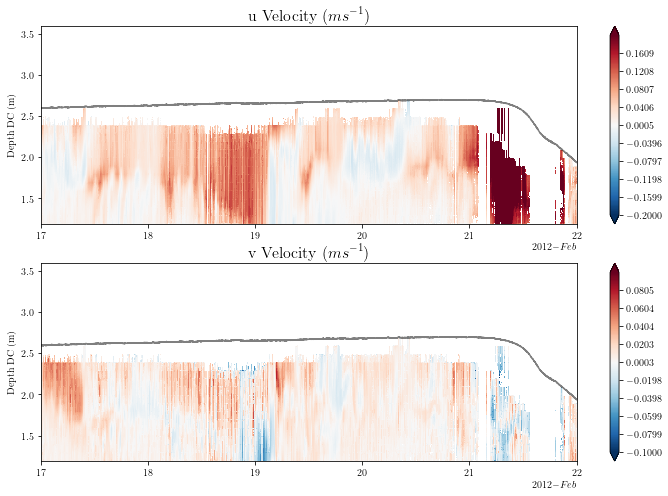

In [25]:
t = dfe.index
y_d = dc.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]['Depth']
x = pd.DatetimeIndex(y_d.index).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.2
umax = 0.2
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

ax1.set_title(r"u Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
ax1.plot(x, y_d,color='k',alpha=0.5)
contourf_ = ax1.contourf(t, y_bin,
                         u,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1)
ax1.set_ylabel(r"Depth DC (m)")

ax2.set_title(r"v Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax2.plot(x, y_d,color='k',alpha=0.5)
contourf_2 = ax2.contourf(t, y_bin,
                          v,
                          levels=level_boundaries_v,
                          cmap=cm.RdBu_r,
                          vmax=vmax, vmin=vmin, extend='both')
cbar = plt.colorbar(contourf_2, ax=ax2)
ax2.set_ylabel(r"Depth DC (m)")

plt.show()

__Del 25 al 4__

In [26]:
dfe = df_east.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]
dfn = df_north.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]

In [27]:
u, v = earth_to_uv(dfe, dfn, 1.103577885)

## Viento 

Importar datos de viento

In [33]:
wind_data1 = w.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]
wind_data2 = w.loc[datetime.date(2012,2,25):datetime.date(2012,3,8)]

In [34]:
north_w1 = wind_data1['Speed']*np.sin(np.pi*wind_data['Direction']/180).to_frame()
east_w1 = wind_data1['Speed']*np.cos(np.pi*wind_data['Direction']/180).to_frame()

north_w2 = wind_data2['Speed']*np.sin(np.pi*wind_data['Direction']/180).to_frame()
east_w2 = wind_data2['Speed']*np.cos(np.pi*wind_data['Direction']/180).to_frame()

In [35]:
u_w1, v_w1 = earth_to_uv(east_w1, north_w1, 1.10769103)
u_w2, v_w2 = earth_to_uv(east_w2, north_w2, 1.103577885)

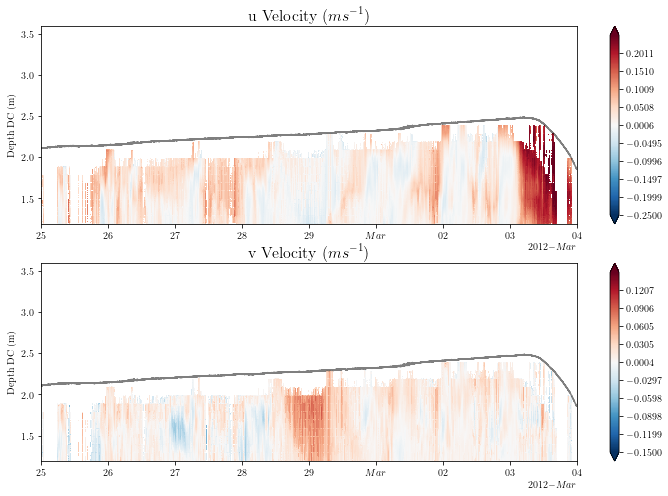

In [32]:
t = dfe.index
y_d = dc.loc[datetime.date(2012,2,25):datetime.date(2012,3,4)]['Depth']
x = pd.DatetimeIndex(y_d.index).tz_localize('UTC').tz_convert('America/Los_Angeles')
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.25
umax = 0.25
vmin = -0.15
vmax = 0.15
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=2, figsize=(12, 12))

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

ax1.set_title(r"u Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
ax1.plot(x, y_d,color='k',alpha=0.5)
contourf_ = ax1.contourf(t, y_bin,
                         u,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1)
ax1.set_ylabel(r"Depth DC (m)")

ax2.set_title(r"v Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax2.plot(x, y_d,color='k',alpha=0.5)
contourf_2 = ax2.contourf(t, y_bin,
                          v,
                          levels=level_boundaries_v,
                          cmap=cm.RdBu_r,
                          vmax=vmax, vmin=vmin, extend='both')
cbar = plt.colorbar(contourf_2, ax=ax2)
ax2.set_ylabel(r"Depth DC (m)")

ax3.set_title(r"v Wind velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax3.plot(x, y_d,color='k',alpha=0.5)


plt.show()

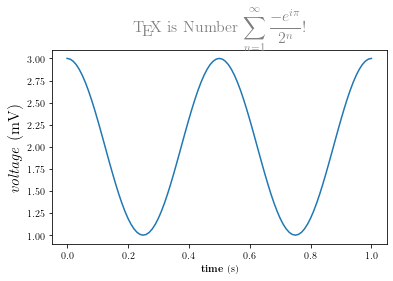

In [153]:
t = np.arange(0.0, 1.0 + 0.01, 0.01)
s = np.cos(4 * np.pi * t) + 2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(t, s)

plt.xlabel(r'\textbf{time} (s)')
plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
plt.title(r"\TeX\ is Number "
          r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
          fontsize=16, color='gray')
# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)

plt.savefig('tex_demo')
plt.show()